In [41]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import scipy.stats as stats

# Optional: XGBoost / LightGBM
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False

try:
    from lightgbm import LGBMClassifier
    lgbm_available = True
except ImportError:
    lgbm_available = False

### Select Features and Target

In [ ]:
df = pd.read_pickle("../data/processed/fraud_df.pkl") # Read the pickle file
X = df.drop('fraud_reported', axis=1)
y = df['fraud_reported'].map({'Y': 1, 'N': 0})  # Convert target to binary

In [24]:
# Convert date and time features to numeric

X['year_policy_bind_year'] = X['policy_bind_date'].dt.year
X['month_policy_bind_year'] = X['policy_bind_date'].dt.month
X['day_policy_bind_year'] = X['policy_bind_date'].dt.day
# Dann entfernen:
X = X.drop(columns=['policy_bind_date'])

X['year_incident_date'] = X['incident_date'].dt.year
X['month_incident_date'] = X['incident_date'].dt.month
X['day_incident_date'] = X['incident_date'].dt.day
# Dann entfernen:
X = X.drop(columns=['incident_date'])

### Handle Categorical Features (One-Hot Encoding)

In [25]:
X = pd.get_dummies(X, drop_first=True)

### Check for Low-Variance or Constant Columns

In [26]:
selector = VarianceThreshold(threshold=0.01)
selector.fit(X)
low_variance_cols = X.columns[~selector.get_support()]
print("Low variance features:", low_variance_cols)

Low variance features: Index(['year_incident_date', 'incident_location_1028 Sky Lane',
       'incident_location_1030 Pine Lane',
       'incident_location_1087 Flute Drive',
       'incident_location_1091 1st Drive', 'incident_location_1102 Apache Hwy',
       'incident_location_1110 4th Drive', 'incident_location_1123 5th Lane',
       'incident_location_1126 Texas Hwy', 'incident_location_1128 Maple Lane',
       ...
       'incident_location_9878 Washington Ave',
       'incident_location_9879 Apache Drive',
       'incident_location_9910 Maple Ave',
       'incident_location_9911 Britain Lane',
       'incident_location_9918 Andromedia Drive',
       'incident_location_9929 Rock Drive', 'incident_location_9935 4th Drive',
       'incident_location_9942 Tree Ave', 'incident_location_9980 Lincoln Ave',
       'incident_location_9988 Rock Ridge'],
      dtype='object', length=1000)


### Correlation with Target (Categorical Features)

In [40]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest

# get all object columns
object_cols = df.select_dtypes(include=['object']).columns.tolist()
print(object_cols)

# Encode categorical features
X_cat = df[object_cols].astype(str).apply(LabelEncoder().fit_transform)
y = df['fraud_reported'].map({'Y': 1, 'N': 0})  # target to 0/1

# Chi-squared test
chi_scores = chi2(X_cat, y)
chi_results = pd.Series(chi_scores[1], index=X_cat.columns)
print(chi_results.sort_values())  # smaller p-value = more important


['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'property_damage', 'police_report_available', 'auto_make', 'auto_model', 'fraud_reported']
fraud_reported             8.935015e-166
incident_severity           1.539047e-28
incident_location           3.094072e-04
authorities_contacted       3.726509e-04
collision_type              4.121145e-03
insured_hobbies             7.086420e-03
incident_state              5.171057e-02
incident_type               1.116985e-01
incident_city               1.295691e-01
auto_make                   1.701591e-01
policy_csl                  3.321793e-01
property_damage             4.200066e-01
policy_state                4.427006e-01
police_report_available     4.641727e-01
insured_relationship        4.719475e-01
insured_sex        

### Correlation with Target (Numerical Features)

In [45]:
from scipy.stats import pointbiserialr

# Get only numeric columns
num_cols = X.select_dtypes(include=['number']).columns.tolist()

# Compute correlations
correlations = {}
for col in num_cols:
    corr, _ = pointbiserialr(X[col], y)
    correlations[col] = corr

# Convert to DataFrame
corr_df = pd.Series(correlations).sort_values(ascending=False)
print(corr_df)

vehicle_claim                  0.170049
total_claim_amount             0.163651
property_claim                 0.137835
injury_claim                   0.090975
day_policy_bind_year           0.063040
umbrella_limit                 0.058622
number_of_vehicles_involved    0.051839
witnesses                      0.049497
bodily_injuries                0.033877
months_as_customer             0.020544
insured_zip                    0.019368
policy_deductable              0.014817
age                            0.012143
auto_year                      0.007928
incident_hour_of_the_day       0.004316
days_active                    0.000930
year_policy_bind_year         -0.000059
policy_annual_premium         -0.014480
capital-loss                  -0.014863
capital-gains                 -0.019173
incident_month                -0.028847
month_incident_date           -0.028847
policy_number                 -0.029443
month_policy_bind_year        -0.035180
day_incident_date             -0.045955


c:\Users\dakno\OneDrive\Projekte\Insurance-Fraud-Detection\venv\Lib\site-packages\scipy\stats\_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


### Correlation Features (Categorical)

In [42]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Example:
cramers_v(df['collision_type'], df['incident_type'])


np.float64(0.5792057712023508)

In [43]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Create empty DataFrame for results
cramer_matrix = pd.DataFrame(np.zeros((len(cat_cols), len(cat_cols))), 
                             index=cat_cols, columns=cat_cols)

# Fill the matrix
for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 == col2:
            cramer_matrix.loc[col1, col2] = 1.0
        else:
            val = cramers_v(df[col1].astype(str), df[col2].astype(str))
            cramer_matrix.loc[col1, col2] = val

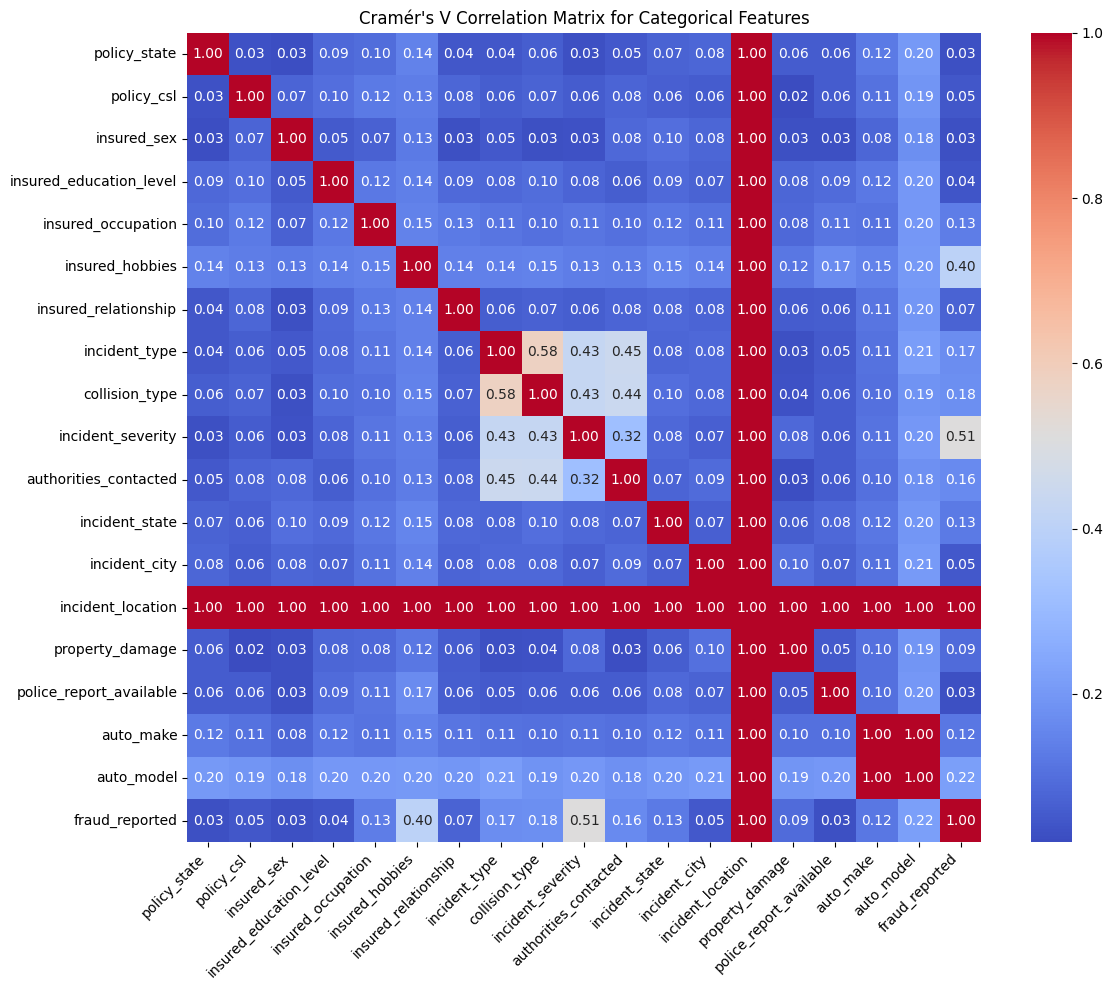

In [44]:
plt.figure(figsize=(12, 10))
sns.heatmap(cramer_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cramér's V Correlation Matrix for Categorical Features")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Correlation Features (Numerical)

<Axes: >

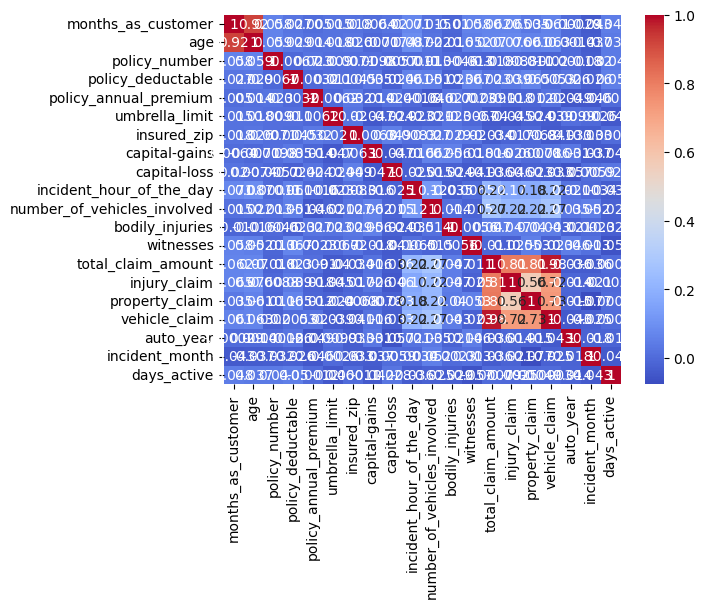

In [46]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')  # Heatmap of the correlationmatrix

### Train-Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Model choice (Cross-Validation mit ROC-AUC)

In [64]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier()
}

if xgb_available:
    models["XGBoost"] = XGBClassifier(scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
                                      use_label_encoder=False, eval_metric='logloss')
if lgbm_available:
    models["LightGBM"] = LGBMClassifier(class_weight='balanced')

In [66]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    results[name] = scores
    print(f"{name}: ROC-AUC mean={scores.mean():.3f}, std={scores.std():.3f}")


Logistic Regression: ROC-AUC mean=0.588, std=0.042
Decision Tree: ROC-AUC mean=0.750, std=0.026
Random Forest: ROC-AUC mean=0.821, std=0.031
Gradient Boosting: ROC-AUC mean=0.880, std=0.021
XGBoost: ROC-AUC mean=0.855, std=0.020
LightGBM: ROC-AUC mean=0.851, std=0.025


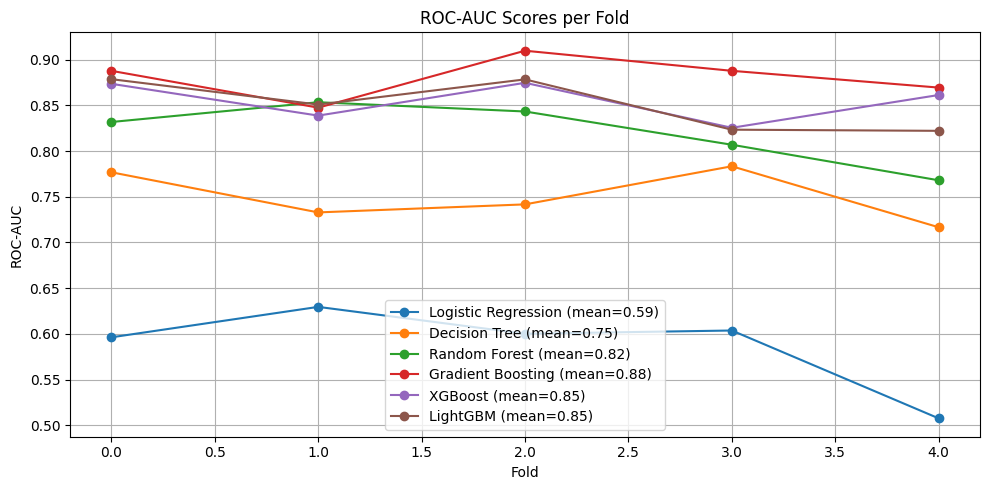

In [67]:
plt.figure(figsize=(10, 5))
for name, scores in results.items():
    plt.plot(scores, label=f"{name} (mean={np.mean(scores):.2f})", marker='o')
plt.title("ROC-AUC Scores per Fold")
plt.xlabel("Fold")
plt.ylabel("ROC-AUC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Train a Gradient Boosting model

In [10]:
# Identify types of the columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

In [11]:
# Model
gb = GradientBoostingClassifier(random_state=42)

# Pipeline mit SMOTE + RandomForest

pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', gb)
])

In [13]:
#### Use GridSearch for hyperparameter optimization

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': [3, 5],
    'clf__subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(pipe,
                           param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(grid_search.best_params_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__subsample': 1.0}


### Evaluate the model

In [14]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87       151
           1       0.61      0.55      0.58        49

    accuracy                           0.81       200
   macro avg       0.74      0.72      0.73       200
weighted avg       0.80      0.81      0.80       200


ROC AUC Score: 0.826327882146236


### ROC Curve

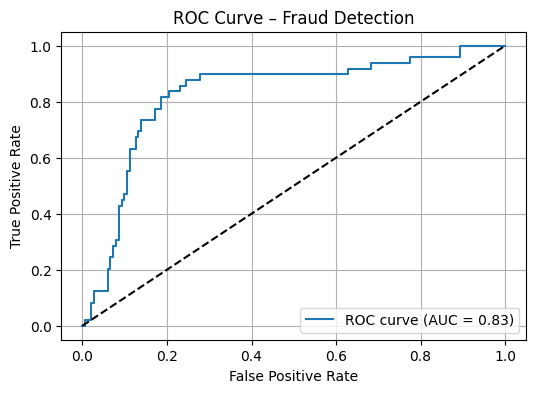

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale Linie = Zufall
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Fraud Detection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Precision-Recall Curve

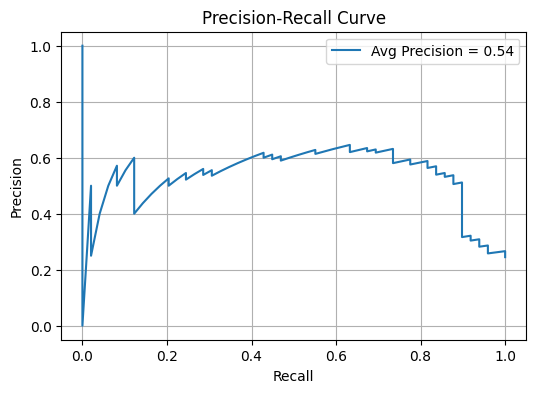

In [17]:

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"Avg Precision = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

### Train a Random Forest model

In [46]:
# Pipeline mit SMOTE + RandomForest

pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])


In [ ]:
#### Use GridSearch for hyperparameter optimization

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt']
}

grid_search = GridSearchCV(pipe,
                           param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(grid_search.best_params_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}


### Evaluate the model

In [51]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

[[143   8]
 [ 46   3]]
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       151
           1       0.27      0.06      0.10        49

    accuracy                           0.73       200
   macro avg       0.51      0.50      0.47       200
weighted avg       0.64      0.73      0.66       200

ROC-AUC: 0.6800919043113934


### ROC Curve

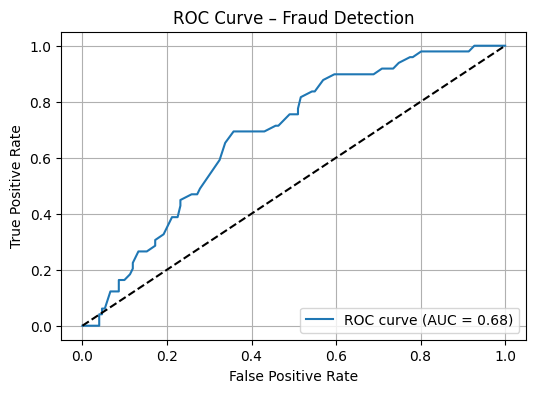

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale Linie = Zufall
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Fraud Detection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Precision Recall Curve 

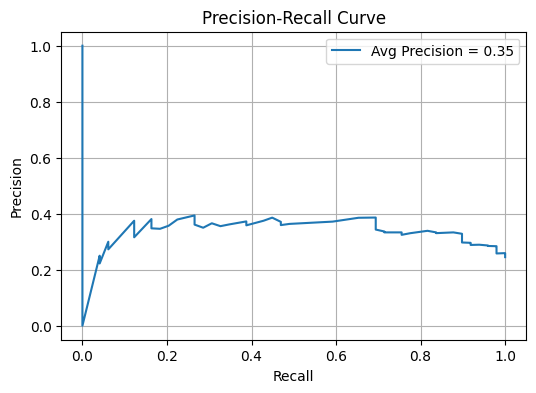

In [ ]:

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"Avg Precision = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


### Feature Importances

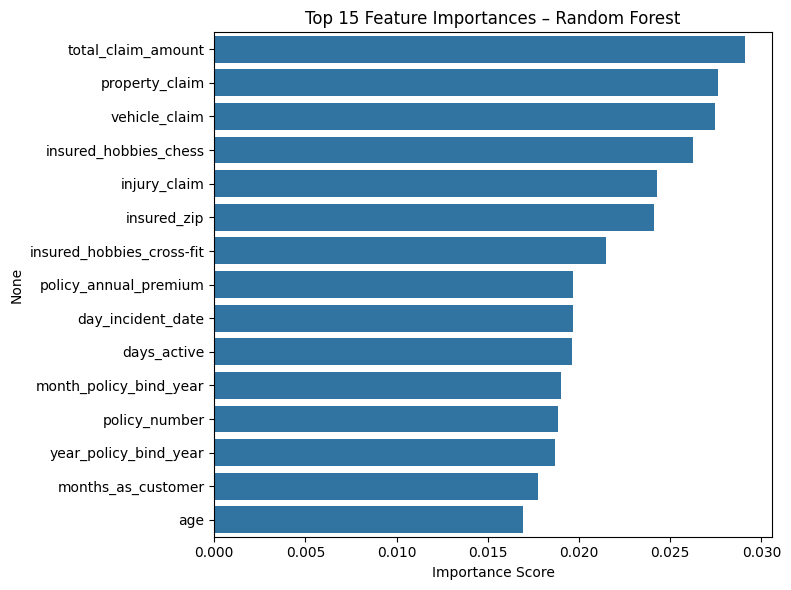

In [ ]:
rf = best_model.named_steps['clf']

importances = pd.Series(rf.feature_importances_, index=X.columns)
top_importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_importances, y=top_importances.index)
plt.title("Top 15 Feature Importances – Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()
